In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Deep learning & graph
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# RDKit
from rdkit import Chem
from rdkit.Chem import AllChem


In [2]:
# Load Tox21 data
df = pd.read_csv("tox21.csv")  # Ensure this file is uploaded in your Colab environment
df = df[['smiles', 'SR-HSE']].dropna()

# Updated Morgan Fingerprint Generator
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

generator = GetMorganGenerator(radius=2, fpSize=1024)

def mol_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(generator.GetFingerprint(mol))
    return None

# Convert SMILES to fingerprints
fps, labels = [], []
for _, row in df.iterrows():
    fp = mol_to_fp(row['smiles'])
    if fp is not None:
        fps.append(fp)
        labels.append(row['SR-HSE'])

X, y = np.array(fps), np.array(labels)


[13:03:26] WARNING: not removing hydrogen atom without neighbors


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
pos_weight = torch.tensor(weights[1] / weights[0])


In [4]:
class ToxicityNet(nn.Module):
    def __init__(self):
        super(ToxicityNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# Prepare tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float().unsqueeze(1)
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float().unsqueeze(1)

# Training loop
model = ToxicityNet()
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

torch.save(model.state_dict(), "tox_model.pt")


Epoch 1: Loss = 1.3065
Epoch 2: Loss = 1.2969
Epoch 3: Loss = 1.2842
Epoch 4: Loss = 1.2674
Epoch 5: Loss = 1.2448
Epoch 6: Loss = 1.2137
Epoch 7: Loss = 1.1772
Epoch 8: Loss = 1.1343
Epoch 9: Loss = 1.0832
Epoch 10: Loss = 1.0278
Epoch 11: Loss = 0.9664
Epoch 12: Loss = 0.9063
Epoch 13: Loss = 0.8500
Epoch 14: Loss = 0.7909
Epoch 15: Loss = 0.7270
Epoch 16: Loss = 0.6784
Epoch 17: Loss = 0.6211
Epoch 18: Loss = 0.5691
Epoch 19: Loss = 0.5257
Epoch 20: Loss = 0.4756
Epoch 21: Loss = 0.4371
Epoch 22: Loss = 0.3983
Epoch 23: Loss = 0.3618
Epoch 24: Loss = 0.3357
Epoch 25: Loss = 0.3059
Epoch 26: Loss = 0.2791
Epoch 27: Loss = 0.2531
Epoch 28: Loss = 0.2352
Epoch 29: Loss = 0.2114
Epoch 30: Loss = 0.1910


In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score

model.eval()
logits = model(X_test_tensor)
probs = torch.sigmoid(logits).detach().numpy()
preds_binary = (probs > 0.5).astype(int)

acc = accuracy_score(y_test, preds_binary)
roc = roc_auc_score(y_test, probs)
print(f"Accuracy: {acc:.4f}, ROC-AUC: {roc:.4f}")

df_viz = pd.DataFrame({"Predicted Probability": probs.flatten(), "Actual Label": y_test.flatten()})
fig = px.histogram(df_viz, x="Predicted Probability", color=df_viz["Actual Label"].astype(str),
                   barmode="overlay", title="Prediction Probability Distribution")
fig.show()


Accuracy: 0.9011, ROC-AUC: 0.6676


In [6]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies, rocs = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold+1}")
    model = ToxicityNet()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    X_train_tensor = torch.tensor(X[train_idx]).float()
    y_train_tensor = torch.tensor(y[train_idx]).float().unsqueeze(1)
    X_val_tensor = torch.tensor(X[val_idx]).float()
    y_val_tensor = torch.tensor(y[val_idx]).float().unsqueeze(1)

    for epoch in range(30):
        model.train()
        optimizer.zero_grad()
        out = model(X_train_tensor)
        loss = criterion(out, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    preds = model(X_val_tensor).detach().numpy()
    preds_binary = (preds > 0.5).astype(int)

    acc = accuracy_score(y[val_idx], preds_binary)
    roc = roc_auc_score(y[val_idx], preds)
    accuracies.append(acc)
    rocs.append(roc)
    print(f"Accuracy: {acc:.4f}, ROC-AUC: {roc:.4f}")

print(f"\nAvg Accuracy: {np.mean(accuracies):.4f}, Avg ROC-AUC: {np.mean(rocs):.4f}")



Fold 1
Accuracy: 0.9134, ROC-AUC: 0.6759

Fold 2
Accuracy: 0.9219, ROC-AUC: 0.7198

Fold 3
Accuracy: 0.9180, ROC-AUC: 0.6641

Fold 4
Accuracy: 0.9165, ROC-AUC: 0.7039

Fold 5
Accuracy: 0.9180, ROC-AUC: 0.6340

Avg Accuracy: 0.9176, Avg ROC-AUC: 0.6795


In [7]:
import torch
from rdkit import Chem
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

def atom_to_features_gcn(atom):
    return [
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        atom.GetNumExplicitHs(),
        atom.GetNumImplicitHs(),
        atom.GetIsAromatic(),
        atom.GetMass(),
        int(atom.IsInRing()),
        int(atom.GetChiralTag()),
        int(atom.GetHybridization())
    ]


def smiles_to_graph(smiles, label):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    atoms = [atom_to_features_gcn(atom) for atom in mol.GetAtoms()]
    edges = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edges += [[i, j], [j, i]]
    return Data(
        x=torch.tensor(atoms, dtype=torch.float),
        edge_index=torch.tensor(edges, dtype=torch.long).t().contiguous(),
        y=torch.tensor([label], dtype=torch.float)
    )

graph_list = [smiles_to_graph(row['smiles'], row['SR-HSE']) for _, row in df.iterrows()]
graph_list = [g for g in graph_list if g is not None]


[13:03:45] WARNING: not removing hydrogen atom without neighbors


In [8]:
from random import choices
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

# 1. Split into train/test
train_graphs, test_graphs = train_test_split(
    graph_list, test_size=0.2, stratify=[g.y.item() for g in graph_list], random_state=42
)

# 2. Balance the training set
toxic = [g for g in train_graphs if g.y.item() == 1]
non_toxic = [g for g in train_graphs if g.y.item() == 0]
toxic_upsampled = choices(toxic, k=len(non_toxic))  # upsample to match
train_graphs_balanced = non_toxic + toxic_upsampled

# 3. Loaders
train_loader = DataLoader(train_graphs_balanced, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32)

# 4. Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE)
        loss = self.alpha * (1 - pt) ** self.gamma * BCE
        return loss.mean()

# 5. Rich GCN Model
class RichGCNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(10, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = GCNConv(64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# 6. Training
gnn = RichGCNModel()
optimizer = optim.Adam(gnn.parameters(), lr=0.001)
loss_fn = FocalLoss(alpha=0.25, gamma=2.0)

for epoch in range(40):
    gnn.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = gnn(batch)
        loss = loss_fn(out, batch.y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# 7. Save model
torch.save(gnn.state_dict(), "gcn_model.pt")


Epoch 1: Loss = 12.3552
Epoch 2: Loss = 11.6987
Epoch 3: Loss = 11.5087
Epoch 4: Loss = 11.3516
Epoch 5: Loss = 11.0372
Epoch 6: Loss = 10.8276
Epoch 7: Loss = 10.6924
Epoch 8: Loss = 10.5455
Epoch 9: Loss = 10.4237
Epoch 10: Loss = 10.1036
Epoch 11: Loss = 9.8674
Epoch 12: Loss = 9.6282
Epoch 13: Loss = 9.5379
Epoch 14: Loss = 9.3837
Epoch 15: Loss = 9.1642
Epoch 16: Loss = 9.0637
Epoch 17: Loss = 8.9081
Epoch 18: Loss = 8.8186
Epoch 19: Loss = 8.7428
Epoch 20: Loss = 8.5393
Epoch 21: Loss = 8.4428
Epoch 22: Loss = 8.3589
Epoch 23: Loss = 8.1729
Epoch 24: Loss = 8.3536
Epoch 25: Loss = 8.0637
Epoch 26: Loss = 7.8841
Epoch 27: Loss = 7.6743
Epoch 28: Loss = 7.5485
Epoch 29: Loss = 7.4686
Epoch 30: Loss = 7.4676
Epoch 31: Loss = 7.4335
Epoch 32: Loss = 7.3320
Epoch 33: Loss = 7.1483
Epoch 34: Loss = 6.8631
Epoch 35: Loss = 6.9407
Epoch 36: Loss = 6.8493
Epoch 37: Loss = 6.8033
Epoch 38: Loss = 6.7108
Epoch 39: Loss = 6.5782
Epoch 40: Loss = 6.7144


In [9]:
import numpy as np
import pandas as pd
import plotly.express as px
import torch
from sklearn.metrics import accuracy_score, roc_auc_score

# Evaluate the GCN model
from sklearn.metrics import precision_recall_curve, classification_report

gnn.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        out = gnn(batch)
        probs = torch.sigmoid(out)
        all_preds.extend(probs.cpu().numpy())
        all_labels.extend(batch.y.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

precision, recall, thresholds = precision_recall_curve(all_labels, all_preds)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_threshold = thresholds[np.argmax(f1_scores)]

# 🔽 Save threshold for use in Streamlit/Dash
np.save("gcn_best_threshold.npy", best_threshold)
print(f"Best threshold (F1): {best_threshold:.3f}")

preds_binary = (all_preds > best_threshold).astype(int)

print("\n===== GCN Final Evaluation =====")
print(f"Accuracy: {accuracy_score(all_labels, preds_binary):.4f}")
print(f"ROC-AUC: {roc_auc_score(all_labels, all_preds):.4f}")
print(classification_report(all_labels, preds_binary, target_names=["Non-toxic", "Toxic"]))


#all_preds = np.array(all_preds)
#all_labels = np.array(all_labels)
#preds_binary = (all_preds > 0.5).astype(int)

gnn_acc = accuracy_score(all_labels, preds_binary)
gnn_roc = roc_auc_score(all_labels, all_preds)
print(f"GCN Model - Accuracy: {gnn_acc:.4f}, ROC-AUC: {gnn_roc:.4f}")

# Visualization
df_gnn_viz = pd.DataFrame({
    "Predicted Probability": all_preds.flatten(),
    "Actual Label": all_labels.flatten()
})
fig_gnn = px.histogram(df_gnn_viz, x="Predicted Probability", 
                       color=df_gnn_viz["Actual Label"].astype(str),
                       barmode="overlay", 
                       title="GCN Model - Prediction Probability Distribution")
fig_gnn.show()


Best threshold (F1): 0.498

===== GCN Final Evaluation =====
Accuracy: 0.9243
ROC-AUC: 0.7838
              precision    recall  f1-score   support

   Non-toxic       0.96      0.96      0.96      1220
       Toxic       0.33      0.32      0.33        74

    accuracy                           0.92      1294
   macro avg       0.65      0.64      0.64      1294
weighted avg       0.92      0.92      0.92      1294

GCN Model - Accuracy: 0.9243, ROC-AUC: 0.7838


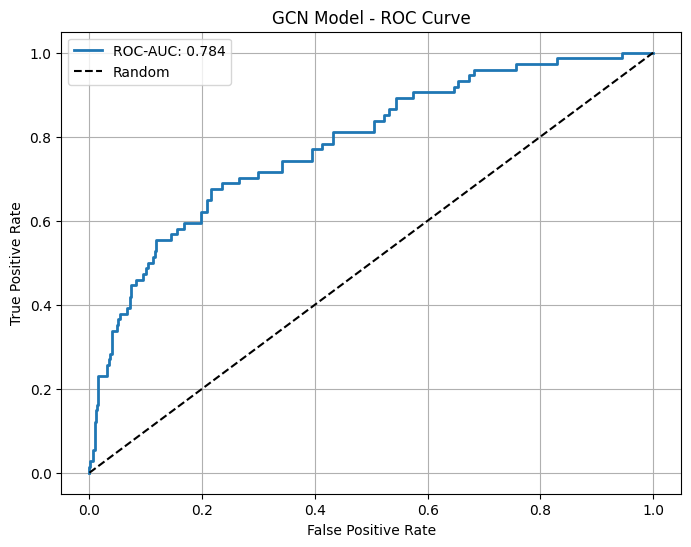

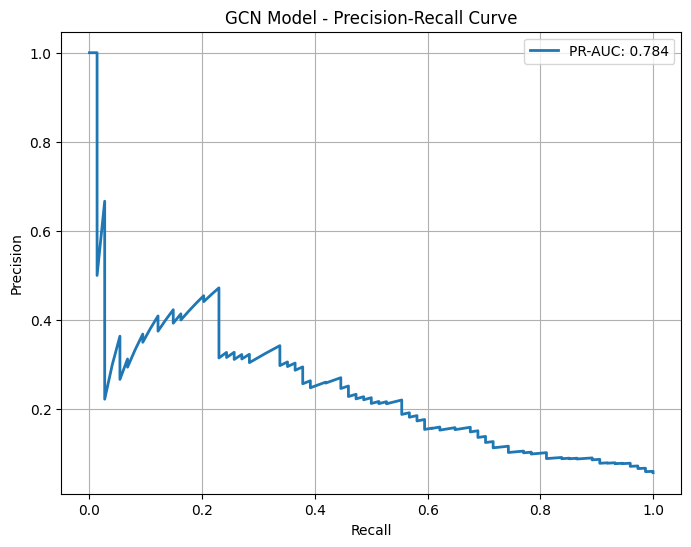

In [10]:
from sklearn.metrics import roc_curve, precision_recall_curve

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-AUC: {gnn_roc:.3f}', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("GCN Model - ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_preds)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR-AUC: {roc_auc_score(all_labels, all_preds):.3f}", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("GCN Model - Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
from dash import Dash, html, dcc, Input, Output
import dash
import plotly.express as px
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
import threading, webbrowser, nest_asyncio
nest_asyncio.apply()

# ============================
# Fingerprint-based MLP Model
# ============================
class ToxicityNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.model(x)

model = ToxicityNet()
try:
    model.load_state_dict(torch.load("tox_model.pt"))
    model.eval()
    model_loaded = True
except:
    model_loaded = False

fp_generator = GetMorganGenerator(radius=2, fpSize=1024)
def predict_toxicity(smiles):
    if not model_loaded:
        return "Model not loaded", 0.0
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return "Invalid SMILES", 0.0
        fp = fp_generator.GetFingerprint(mol)
        fp_array = np.array(fp).reshape(1, -1)
        with torch.no_grad():
            logits = model(torch.tensor(fp_array).float())
            prob = torch.sigmoid(logits).item()
        return ("Toxic" if prob > 0.5 else "Non-toxic"), prob
    except Exception as e:
        return f"Error: {str(e)}", 0.0

# ============================
# GCN Model
# ============================
class RichGCNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(10, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = GCNConv(64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


gcn_model = RichGCNModel()
try:
    gcn_model.load_state_dict(torch.load("gcn_model.pt"))
    gcn_model.eval()
    gcn_model_loaded = True
except:
    gcn_model_loaded = False

def atom_to_features_gcn(atom):
    return [
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        atom.GetNumExplicitHs(),
        atom.GetNumImplicitHs(),
        atom.GetIsAromatic(),
        atom.GetMass(),
        int(atom.IsInRing()),
        int(atom.GetChiralTag()),
        int(atom.GetHybridization())
    ]

def smiles_to_graph_gcn(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    atoms = [atom_to_features_gcn(atom) for atom in mol.GetAtoms()]
    edges = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edges += [[i, j], [j, i]]
    if not edges:
        edges = [[0, 0]]
    return Data(
        x=torch.tensor(atoms, dtype=torch.float),
        edge_index=torch.tensor(edges, dtype=torch.long).t().contiguous(),
        batch=torch.zeros(len(atoms), dtype=torch.long)
    )

def predict_toxicity_gcn(smiles):
    if not gcn_model_loaded:
        return "GCN Model not loaded", 0.0
    try:
        graph_data = smiles_to_graph_gcn(smiles)
        if graph_data is None:
            return "Invalid SMILES", 0.0
        with torch.no_grad():
            logits = gcn_model(graph_data)
            prob = torch.sigmoid(logits).item()
        return ("Toxic" if prob > best_threshold else "Non-toxic"), prob
    except Exception as e:
        return f"Error: {str(e)}", 0.0

# ============================
# Dash App with Tabs
# ============================
app = Dash(__name__, suppress_callback_exceptions=True)
app.title = "Drug Toxicity Prediction"

# Histogram samples
fig_sample_fp = px.histogram(
    x=np.random.beta(2, 5, 100),
    color=np.random.binomial(1, 0.3, 100).astype(str),
    nbins=20,
    title="Sample Prediction Probability Distribution",
    labels={"x": "Predicted Probability", "color": "Actual Label"}
)

fig_sample_gcn = px.histogram(
    x=np.random.beta(2, 5, 100),
    color=np.random.binomial(1, 0.3, 100).astype(str),
    nbins=20,
    title="GCN Model - Sample Prediction Probability Distribution",
    labels={"x": "Predicted Probability", "color": "Actual Label"}
)

# App layout with Tabs
app.layout = html.Div([
    html.H1("🧪 Drug Toxicity Prediction Dashboard", style={"textAlign": "center", "color": "#2c3e50"}),
    dcc.Tabs(id='tabs', value='tab-fp', children=[
        dcc.Tab(label='Fingerprint Model', value='tab-fp'),
        dcc.Tab(label='GCN Model', value='tab-gcn'),
    ]),
    html.Div(id='tab-content')
])

# ============================
# Tab Content Callbacks
# ============================
@app.callback(Output('tab-content', 'children'), Input('tabs', 'value'))
def render_tab(tab):
    if tab == 'tab-fp':
        return html.Div([
            html.Div([dcc.Graph(figure=fig_sample_fp)], style={"width": "48%", "display": "inline-block"}),
            html.Div([                html.H3("Make a Prediction"),
                html.Label("Enter SMILES string:"),
                dcc.Input(id='fp-smiles', value='CCO', type='text', debounce=True,
                          style={"width": "100%", "padding": "10px", "marginBottom": "10px"}),
                html.Div(id='fp-output', style={"marginTop": "1rem", "fontSize": "18px", "padding": "10px"}),
                html.Div(id='fp-prob', style={"marginTop": "1rem", "fontSize": "16px"}),
                html.Hr(),
                html.H4("Example SMILES:"), html.P("• CCO"), html.P("• CC(=O)O"), html.P("• c1ccccc1"),
            ], style={"width": "48%", "float": "right", "padding": "20px"}),
            html.Div(id='fp-info', style={"marginTop": "2rem", "padding": "20px"})
        ])
    elif tab == 'tab-gcn':
        return html.Div([
            html.Div([dcc.Graph(figure=fig_sample_gcn)], style={"width": "48%", "display": "inline-block"}),
            html.Div([
                html.H3("🔬 Graph Neural Network Prediction"),
                html.P("This model uses molecular graph structure and atom features", style={"fontSize": "14px"}),
                html.Label("Enter SMILES string:"),
                dcc.Input(id='gcn-smiles', value='CCO', type='text', debounce=True,
                          style={"width": "100%", "padding": "10px", "marginBottom": "10px"}),
                html.Div(id='gcn-output', style={"marginTop": "1rem", "fontSize": "18px", "padding": "10px"}),
                html.Div(id='gcn-prob', style={"marginTop": "1rem", "fontSize": "16px"}),
                html.Hr(),
                html.H4("Test Molecules:"), html.P("• c1ccc(cc1)N"), html.P("• C=CC=O"),
            ], style={"width": "48%", "float": "right", "padding": "20px"}),
            html.Div(id='gcn-info', style={"marginTop": "2rem", "padding": "20px"})
        ])

# ============================
# Callback for Fingerprint Tab
# ============================
@app.callback(
    [Output('fp-output', 'children'), Output('fp-output', 'style'),
     Output('fp-prob', 'children'), Output('fp-info', 'children')],
    Input('fp-smiles', 'value')
)
def update_fp_tab(smiles):
    if not smiles:
        return "Enter SMILES", {"color": "gray"}, "", ""
    result, prob = predict_toxicity(smiles)
    color = "green" if "Non" in result else "red" if "Toxic" in result else "orange"
    info = html.Div()
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            info = html.Div([
                html.H4("Molecule Info:"),
                html.P(f"Formula: {rdMolDescriptors.CalcMolFormula(mol)}"),
                html.P(f"Weight: {rdMolDescriptors.CalcExactMolWt(mol):.2f}"),
                html.P(f"Atoms: {mol.GetNumAtoms()}"),
                html.P(f"Bonds: {mol.GetNumBonds()}")
            ])
    except: pass
    return result, {"color": color, "fontWeight": "bold"}, f"Probability: {prob:.3f}", info

# ============================
# Callback for GCN Tab
# ============================
@app.callback(
    [Output('gcn-output', 'children'), Output('gcn-output', 'style'),
     Output('gcn-prob', 'children'), Output('gcn-info', 'children')],
    Input('gcn-smiles', 'value')
)
def update_gcn_tab(smiles):
    if not smiles:
        return "Enter SMILES", {"color": "gray"}, "", ""
    result, prob = predict_toxicity_gcn(smiles)
    color = "green" if "Non" in result else "red" if "Toxic" in result else "orange"
    info = html.Div()
    try:
        mol = Chem.MolFromSmiles(smiles)
        graph_data = smiles_to_graph_gcn(smiles)
        if mol and graph_data:
            info = html.Div([
                html.H4("Graph Info:"),
                html.P(f"Formula: {rdMolDescriptors.CalcMolFormula(mol)}"),
                html.P(f"Weight: {rdMolDescriptors.CalcExactMolWt(mol):.2f}"),
                html.P(f"Atoms: {mol.GetNumAtoms()}"),
                html.P(f"Bonds: {mol.GetNumBonds()}"),
                html.P(f"Edges: {graph_data.edge_index.shape[1]}"),
                html.P(f"Node Features: 5")
            ])
    except: pass
    return result, {"color": color, "fontWeight": "bold"}, f"GCN Probability: {prob:.3f}", info

# ============================
# Run App
# ============================
def open_browser():
    webbrowser.open_new("http://127.0.0.1:8050")
threading.Timer(1, open_browser).start()

if __name__ == '__main__':
    app.run(debug=True, port=8050)
